# MIP Control

In [ ]:
import sys
sys.path.append('..')

In [ ]:
%matplotlib notebook  
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [ ]:
from ctrl.system.tf import PID
from ctrl.block.linear import SISO, Gain, Feedback, ShortCircuit
from ctrl.block.logger import Logger
from ctrl.system.tf import DTTF, DTSS

Substitute `HOST` and `PORT` with the IP address and port of your controller:

In [ ]:
from ctrl.client import Controller
HOST, PORT = "localhost", 9999
#HOST, PORT = "192.168.10.102", 9999
mip = Controller(host = HOST, port = PORT)

## Probe the controller

In [ ]:
print(mip.info('all'))

## Attach a logger

In [257]:
mip.add_sink('logger', Logger(), ['clock', 'encoder1','encoder2','imu'])
print(mip.info('sinks'))

> sinks
  1. motor1 >> motor1[enabled]
  2. motor2 >> motor2[enabled]
  3. clock, encoder1, encoder2, imu >> logger[enabled]



## State-Space Controller

In [ ]:
mip.add_signal('theta_reference')
mip.add_signal('phi_reference')

mip.set_signal('theta_reference', 0)
mip.set_signal('phi_reference', 0)

In [ ]:
mip.add_sink('logger', Logger(), ['clock','imu','motor1','motor2','encoder1','encoder2'])

In [ ]:
Ac = np.array([[0,0,0],[0,0,0],[0,0,0]])
Bc = np.array([[0,0],[0,0],[0,0]])
Cc = np.array([[0,0,0]])
Dc = np.array([[0,0]])

ctr = DTSS(Ac,Bc,Cc,Dc)

In [ ]:
mip.add_filter('controller', 
               Feedback(block = MISO(model = ctr)),
               ['imu', 'reference1'], 
               ['motor1'])
mip.add_filter('motor2short', ShortCircuit(), ['motor1'], ['motor2'])

## $\theta$ Control

In [281]:
mip.add_signal('reference1')
mip.set_signal('reference1', -0.4/(2*np.pi))

In [282]:
mip.add_sink('logger', Logger(), ['clock','imu','motor1','motor2','reference1','encoder1','encoder2'])

In [314]:
num = np.array([-1.5000,2.7958,-1.3081])*6*4*2*np.pi*100/7.4
den = np.array([1.0000,-1.6713,0.6710])
ctr = DTTF(num,den)

In [315]:
mip.add_filter('controller', 
               Feedback(block = SISO(model = ctr)),
               ['imu', 'reference1'], 
               ['motor1'])
mip.add_filter('motor2short', ShortCircuit(), ['motor1'], ['motor2'])

In [316]:
print(mip.info('all'))

> Controller with 6 device(s), 8 signal(s), 4 source(s), 3 sink(s), and 2 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. encoder1
  3. encoder2
  4. imu
  5. is_running
  6. motor1
  7. motor2
  8. reference1
> sources
  1. clock[enabled] >> clock
  2. encoder1[enabled] >> encoder1
  3. encoder2[enabled] >> encoder2
  4. imu[disabled] >> imu
> filters
  1. imu, reference1 >> controller[enabled] >> motor1
  2. motor1 >> motor2short[enabled] >> motor2
> sinks
  1. motor1 >> motor1[disabled]
  2. motor2 >> motor2[disabled]
  3. clock, imu, motor1, motor2, reference1, encoder1, encoder2 >> logger[enabled]



In [317]:
mip.set_sink('logger',reset=True)
mip.set_source('clock',reset=True)
with mip:
    time.sleep(2)

In [287]:
log = mip.read_sink('logger')

clock = log[:,0]
imu = log[:,1]
motor1 = log[:,2]
motor2 = log[:,3]
reference1 = log[:,4]
encoder1 = log[:,5]
encoder2 = log[:,6]

<IPython.core.display.Javascript object>


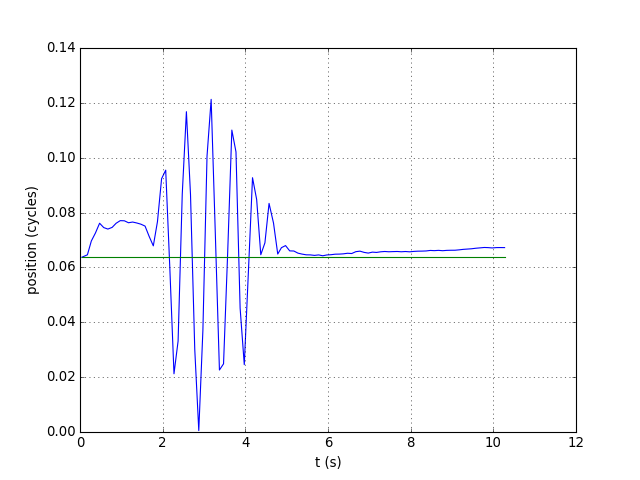

In [289]:
fig = plt.figure(0)

plt.plot(clock, imu, clock, -1*reference1)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

<IPython.core.display.Javascript object>


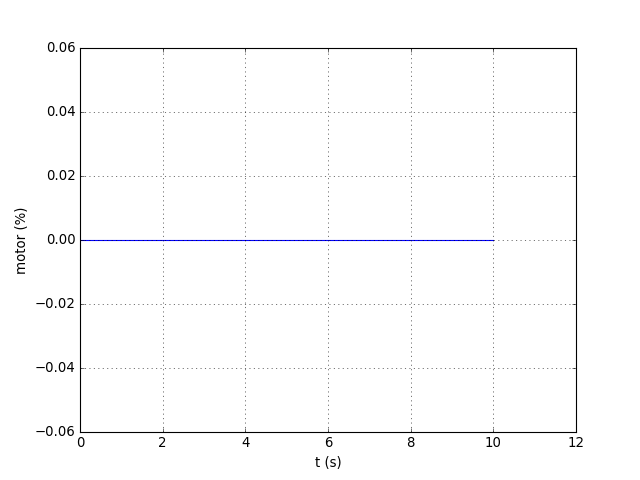

In [239]:
fig = plt.figure(1)

plt.plot(clock, motor1)
# the next lines will make the plot look nicer
plt.xlabel('t (s)')
plt.ylabel('motor (%)')
plt.grid()